# Introduction

This project is completed as part of the [Kaggle's Titanic Competition](https://www.kaggle.com/c/titanic).


The goal of this project to predict what sorts of people were likely to survive.

---


In [0]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from numpy import percentile
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [0]:
# Loading the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 1. Exploratory Analysis with Pandas

Checking the data dimension.

In [3]:
train.shape

(891, 12)

In [4]:
# General information about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**int64**, **object**,  and **float64** are the types of the features.

In [5]:
# Statistical characteristics of numerical features
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Statistical characteristics of categorical features
train.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Fox, Mr. Stanley Hubert",male,1601,G6,S
freq,1,577,7,4,644


Let's see, how many male or female survived?

In [7]:
pd.crosstab(train['Survived'], train['Sex'])

Sex,female,male
Survived,,
0,81,468
1,233,109


233 females and 109 males were survived.  It becomes 68% females and 32% males who survived.

Let's see, what age of people mostly survived?

In [8]:
pd.crosstab(train['Survived'], train['Age'] <= 15)

Age,False,True
Survived,,
0,515,34
1,293,49


There were 83 children on the ship with age less than or equal to 15 years. Among them 59% Survived

In [9]:
pd.crosstab(train['Survived'], (train['Age'] > 15) & (train['Age'] <= 35))

Age,False,True
Survived,,
0,293,256
1,184,158


There were 414 people with age range 16 to 35 in which 38% Survived.

In [10]:
pd.crosstab(train['Survived'], (train['Age'] > 35) & (train['Age'] <= 90))

Age,False,True
Survived,,
0,415,134
1,259,83


There were 217 people in middle or old ages in which 38% Survived.

So, we come to the conclusion that, mostly children were survived in the incident.



---

# 2. Visual Exploratory Analysis

First, we'll check whether the numerical features are normally distributed or not.

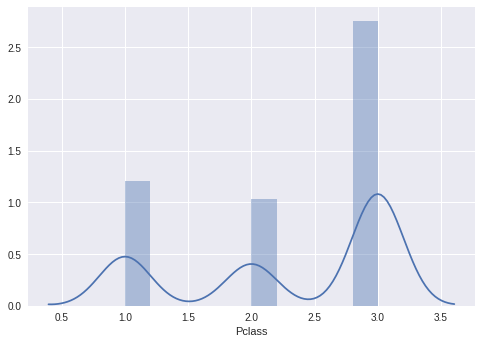

In [11]:
sns.distplot(train['Pclass']);

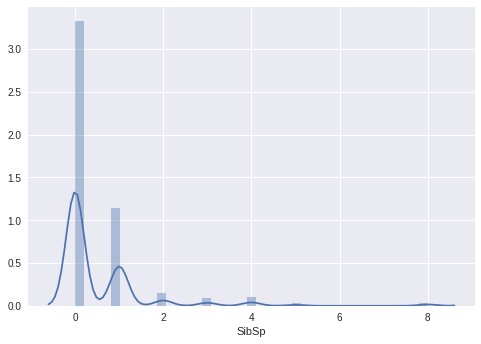

In [12]:
sns.distplot(train['SibSp']);

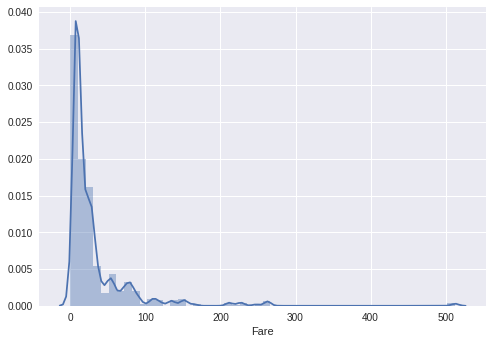

In [13]:
sns.distplot(train['Fare']);

From the plots, we can see that the dataset is not normally distributed.

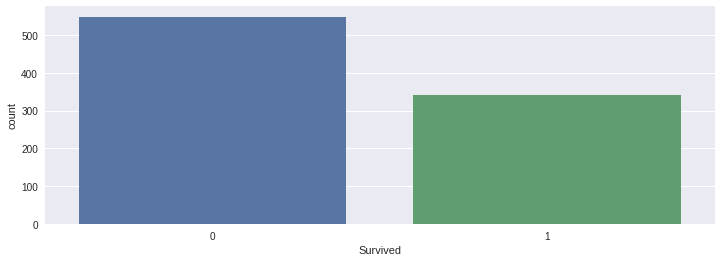

In [14]:
# Checking the frequency distribution of the target variable
train['Survived'].value_counts()
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.countplot(x='Survived', data=train, ax=axes);

Let’s look at the correlations among the numerical variables in our dataset.

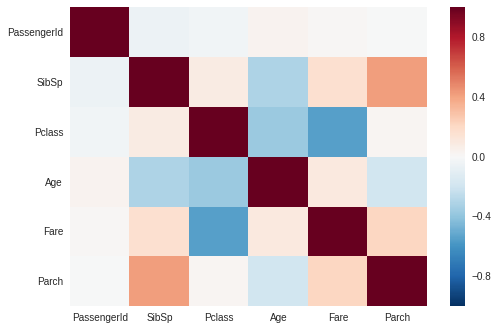

In [15]:
# Drop non-numerical variables
numerical = list(set(train.columns) - set(['Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']))

# Calculate and plot
corr_matrix = train[numerical].corr()
sns.heatmap(corr_matrix);

we can see the correlation between **Parch** and **SibSp**.

Sometimes you can analyze an ordinal variable as numerical one:

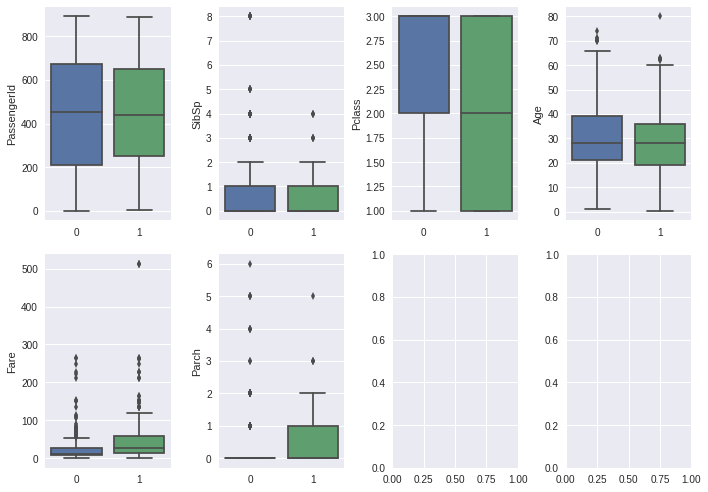

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 7))
for idx, feat in enumerate(numerical): 
    ax = axes[int(idx / 4), idx % 4] 
    sns.boxplot(x='Survived', y=feat, data=train, ax=ax) 
    ax.set_xlabel('') 
    ax.set_ylabel(feat) 
fig.tight_layout();

The above subplots shows some interesting facts.

1. People with 8 and 5 siblings on the ship didn't survive at all.
2. Passenger class (Pclass) Lower class (3) didn't survive at all.

---

# 3. Data Preprocessing

## 3.1. Handling Missing Values

In [17]:
# Checking for missing values
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Training dataset have missing values in Age (float64) and Embarked (object).

In [18]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Test set have missing values in Age (float64) and Fare (float64)

In [0]:
# Function to handle numerical features missing values
def handle_num_missing_values(dataset, columns):
    for i in range(0, len(columns)):
        dataset[columns[i]].fillna(dataset[columns[i]].median(), inplace=True)
   
# Function to handle categorical features missing values
def handle_obj_missing_values(dataset, columns):
    for i in range(0, len(columns)):
        dataset[columns[i]].fillna(method='bfill', inplace=True)
        
handle_num_missing_values(train, ['Age'])
handle_num_missing_values(test, ['Age', 'Fare'])
handle_obj_missing_values(train, ['Embarked'])

## 3.2. Feature Engineering

We'll create a feature from **Cabin**, if empty Cabin, assign feature value as *0*, else *1*.

In [20]:
train['HasCabin'] = train['Cabin'].where(train['Cabin'].isnull(), 1).fillna(0).astype(int)
test['HasCabin'] = test['Cabin'].where(test['Cabin'].isnull(), 1).fillna(0).astype(int)

train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1


In [0]:
def feature_engineering(dataset):
    # Create new feature 'Title' from 'Name'
    dataset['Title'] = dataset['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
    
    # Create new feature 'FamilySize', by adding SibSp, Parch, 1 (The Passenger)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # Create new feature 'IsAlone'
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0
    
    # Create Age bins
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 4, labels=['1 -20', '20-40', '40-60', '60-80'])
    
    # Create Fare Bin
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4, labels=['1-200', '200-400', '400-500', '500-600'])
    
    return dataset

train, test = feature_engineering(train), feature_engineering(test)

In [22]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeBin,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,20-40,1-200
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,20-40,500-600


We have created 5 new features from the existing features.

1. Title: Splitting the titles from name e-g, Mr, Ms, Dr.
2. FamilySize: Adding SibSp (Siblings etc) plus Parch(Parents etc) + the pessengers.
3. IsAlone: Create a new column to check whether the passenger is alone or not on the ship.
4. AgeBin: Create a new feature containing age ranges that describes in which age range the passenger fall into.
5. FareBin: Similary, create a 'FareBin' feature.

Let's check the unique title in the '**Title**' feature

In [23]:
train['Title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Jonkheer          1
 Lady              1
 Don               1
 Capt              1
 Mme               1
 the Countess      1
 Ms                1
 Sir               1
Name: Title, dtype: int64

There are 14 unique values. So we're going to give a unique name 'Misc' to the titles which are occurring less than 10 times.

In [24]:
# Function to clean up rare titles
def clean_titles(dataset):
    title_names = dataset['Title'].value_counts() < 10
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    return dataset

train = clean_titles(train)
test = clean_titles(test)
train['Title'].value_counts()

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeBin,FareBin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,20-40,1-200
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,20-40,500-600
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1,20-40,200-400


We'll create 2 new features (**Last Name and Frequency of Last Name**) from the **Name** column.

In [25]:
def get_frequence_of_last_names(dataset):
    dataset['LName'] = dataset['Name'].str.split(',', expand=True)[0]
    dataset['LName_freq'] = dataset['LName'].map(dataset['LName'].value_counts())
    return dataset

train, test = get_frequence_of_last_names(train), get_frequence_of_last_names(test)
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeBin,FareBin,LName,LName_freq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,Mr,2,0,20-40,1-200,Braund,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,2,0,20-40,500-600,Cumings,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,1,1,20-40,200-400,Heikkinen,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,2,0,20-40,500-600,Futrelle,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,1,1,20-40,200-400,Allen,2


Splitting the target varible from the training set.

In [0]:
y_train = train.iloc[:, 1].values

Removing unnecessary features.

In [0]:
train.drop(['Name', 'LName', 'Survived', 'PassengerId', 'Ticket', 'Cabin'], inplace=True, axis=1)
test.drop(['Name', 'LName', 'PassengerId', 'Ticket', 'Cabin'], inplace=True, axis=1)

In [28]:
train.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeBin,FareBin,LName_freq
0,3,male,22.0,1,0,7.2500,S,0,Mr,2,0,20-40,1-200,2
1,1,female,38.0,1,0,71.2833,C,1,Mrs,2,0,20-40,500-600,1
2,3,female,26.0,0,0,7.9250,S,0,Miss,1,1,20-40,200-400,1
3,1,female,35.0,1,0,53.1000,S,1,Mrs,2,0,20-40,500-600,2
4,3,male,35.0,0,0,8.0500,S,0,Mr,1,1,20-40,200-400,2


## 3.3. Encoding

We are going to label encode Sex, Embarked, Title, AgeBin, and FareBin features.

**Note:** This is one of the most important data preprocessing part. So, please stick with me on this.

**Problem:** 

When you apply encoding and scaling on training and test set. You apply *`fit_transform()`* to the training set and *`transform()`* to the test set.

But, the problem is that using *`fit_transform()`*,  model learns parameters using training set. So, when you apply *`transform()`*, you might face an error:

    *`ValueError: Unseen labels or values`*
    
This error happens when test set have new unseen values that your training set don't have. So, you'll have to take care of the error.

In [29]:
# Label Encoding
le = LabelEncoder()
train['Sex'] = le.fit_transform(train['Sex'])
test['Sex'] = le.transform(test['Sex'])
train['Embarked'] = le.fit_transform(train['Embarked'])
test['Embarked'] = le.transform(test['Embarked'])
train['Title'] = le.fit_transform(train['Title'])
test['Title'] = le.transform(test['Title'])
train['AgeBin'] = le.fit_transform(train['AgeBin'])
test['AgeBin'] = le.transform(test['AgeBin'])
train['FareBin'] = le.fit_transform(train['FareBin'])
test['FareBin'] = le.transform(test['FareBin'])

train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Title,FamilySize,IsAlone,AgeBin,FareBin,LName_freq
0,3,1,22.0,1,0,7.2500,2,0,2,2,0,1,0,2
1,1,0,38.0,1,0,71.2833,0,1,3,2,0,1,3,1
2,3,0,26.0,0,0,7.9250,2,0,1,1,1,1,1,1


In [30]:
# One Hot Encoding
def one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=True)
        #dummies = pd.get_dummies(df[each], prefix=each)
        df = pd.concat([df, dummies], axis=1)
    return df

train = one_hot(train, cols = ['Pclass', 'Embarked', 'Title', 'AgeBin', 'FareBin'])
test = one_hot(test, cols = ['Pclass', 'Embarked', 'Title', 'AgeBin', 'FareBin'])

train.head(3)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Title,FamilySize,...,Title_1,Title_2,Title_3,Title_4,AgeBin_1,AgeBin_2,AgeBin_3,FareBin_1,FareBin_2,FareBin_3
0,3,1,22.0,1,0,7.2500,2,0,2,2,...,0,1,0,0,1,0,0,0,0,0
1,1,0,38.0,1,0,71.2833,0,1,3,2,...,0,0,1,0,1,0,0,0,0,1
2,3,0,26.0,0,0,7.9250,2,0,1,1,...,1,0,0,0,1,0,0,1,0,0


**Note:** I have removed first variable for avoiding the dummy variable trap.

## 3.4. Feature Scaling

In [0]:
sc = StandardScaler()
X_train = sc.fit_transform(train.values)
X_test = sc.transform(test.values)

In [33]:
X_train[3, :]

array([-1.56610693, -1.35557354,  0.4333115 ,  0.43279337, -0.47367361,
        0.42073024,  0.58766427,  1.835115  ,  1.37001673,  0.05915988,
       -1.2316449 ,  0.0168801 ,  1.34475848,  0.0792407 , -0.51015154,
       -1.10792599, -0.30756234,  0.61757214, -0.50665528, -1.17573506,
        2.47547975, -0.1767767 ,  0.76327796, -0.40583972, -0.15911146,
       -0.57951021, -0.57605431,  1.73594744])

# 4. Modeling

I'm going to implement 3 models to the dataset: XGBoost, Support Vector Machines, and Logistic Regression.

**Note:** Parameter tuning has already been done using GridSearchCV.

## 4.1. XGBoost

In [34]:
clf_1 = XGBClassifier(learning_rate = 0.01, gamma = 0.01, max_depth = 4, n_estimators = 200, subsample = 1,
                      colsample_bytree = 1, objective = 'binary:logistic', random_state=0)
clf_1.fit(X_train, y_train)

y_pred_1 = clf_1.predict(X_test)

y_pred_1

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

Above are the predictions I got from the XGBoost model. 

***Kaggle Score: 0.77990***

## 4.2. Logistic Regression

In [35]:
clf_2 = LogisticRegression(C = 0.1, max_iter = 10, penalty = 'l2', solver = 'newton-cg')
clf_2.fit(X_train, y_train)

y_pred_2 = clf_2.predict(X_test)

y_pred_2

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

***Kaggle Score: 0.77033***

## 4.3. Support Vector Machines

In [36]:
clf_3 = SVC(C = 10, gamma = 0.01, kernel = 'rbf', random_state = 0)
clf_3.fit(X_train, y_train)

y_pred_3 = clf_3.predict(X_test)

y_pred_3

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

***Kaggle Score: 0.77511***

# Conclusion

XGboost performed better than SVM and Logistic Regression. I could have make the results better by doing some more feature engineering and parameter tuning.

**Note:** No cheating was done in the competition, because I know how to cheat and get the score 1.  :)